In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [111]:
##########################preprocess data##################################
data = pd.read_excel('data.xlsx', index_col=None)
data=data[data.columns[0:52]]
clinical_col=data.columns[0:14]
outcome_col=data.columns[15:40]
#CT data
CT_col=data.columns[41:52]
CT_data=data[CT_col]
CT_data=CT_data.fillna(CT_data.mean())
CT_data['Liver HU    (Median)']=pd.to_numeric(CT_data['Liver HU    (Median)'],errors='coerce')
CT_data=CT_data.fillna(CT_data.mean())
CT_data=CT_data.astype(float)

##clinical data
CL_data=data[clinical_col]
CL_data=CL_data.drop(columns=['Record ID', 'Visit ID', 'PT ID','BMI >30', 'Met Sx'])
CL_data['BMI']=CL_data['BMI'].fillna(CL_data['BMI'].mean())
(CL_data['Tobacco']=='Yes').sum()/len(CL_data)
CL_data['Tobacco']=CL_data['Tobacco'].fillna('No')
CL_data['Alcohol abuse']=CL_data['Alcohol abuse'].fillna(0)
CL_data['Alcohol abuse']=CL_data['Alcohol abuse'].apply(lambda x: 1 if x!=0 else 0)
for i in ['Sex','Tobacco']:
    CL_data[i] = pd.factorize(CL_data[i])[0] + 1
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: 0.005 if x=='<1%' else x)
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: 0.3 if x=='>30%' else x)
fm=np.mean(CL_data['FRS 10-year risk (%)'][CL_data['FRS 10-year risk (%)']!='X'])
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: fm if x=='X' else x)
for i in ['FRS 10-year risk (%)','FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)']:
    CL_data[i]=pd.to_numeric(CL_data[i],errors='coerce')
    CL_data[i]=CL_data[i].fillna(CL_data[i].mean())
#CL_CT_data=pd.concat([CL_data,CT_data],axis=1)

C:\Users\HP\AppData\Local\Temp/ipykernel_25520/1871121000.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  CT_data=CT_data.fillna(CT_data.mean())


In [112]:
df_CT = CT_data.copy()
df_CT["Age at CT"] = data["Age at CT"]
df_CT = df_CT.drop(["SAT Area (cm2)"], axis = 1)
df_CT = df_CT.drop(["Total Body                Area EA (cm2)"], axis = 1)
df_CT = df_CT.drop(["VAT Area (cm2)"], axis = 1)
df_CT["DEATH [d from CT]"] = data.iloc[:,15]
df_man = df_CT[data["Sex"] == "Male"].copy()
df_woman = df_CT[data["Sex"] == "Female"].copy()

In [113]:
def calculate_BA(df):
    l_slope = []
    l_intercept = []
    l_rvalue = []
    l_pvalue = []
    l_std = []
    for i in range(0, 8):
        slope, intercept, rvalue, pvalue, std = scipy.stats.linregress(df.iloc[:, i], df.iloc[:, -2])
        l_slope.append(slope)
        l_intercept.append(intercept)
        l_rvalue.append(rvalue)
        l_pvalue.append(pvalue)
        l_std.append(std)
        
    l_mse = []
    for i in range(0, 8):
        y_pred = df.iloc[:, i]*l_slope[i]+l_intercept[i]
        y_true = df.iloc[:, -2]
        l_mse.append(mean_squared_error(y_true, y_pred))
        
    BA_E = []
    key = list(df.columns)
    for i in df.to_dict('records'):
        denomi = 0
        numerator = 0
        for j in range(0, 8):
            denomi += (l_slope[j]/l_mse[j])**2
            numerator += (l_slope[j]/(l_mse[j])**2)*(i[key[j]] - l_intercept[j])
        BA_E.append(numerator/denomi)
    
    df["BA_E"] = BA_E
    
    n = 0
    d = 0
    for i in range(0, 8):
        n += (l_rvalue[i]**2)/math.sqrt(1 - l_rvalue[i]**2)
        d += (l_rvalue[i])/math.sqrt(1 - l_rvalue[i]**2)
    r_char = n/d
    
    CA_min = min(df.loc[:, "Age at CT"])
    CA_max = max(df.loc[:, "Age at CT"])
    
    diff = df.loc[:, "Age at CT"] - df.loc[:, "BA_E"]
    diff -= sum(diff)/len(diff)
    temp = sum(diff**2)/len(diff)
    s2_BA = temp - ((1-r_char**2)/(r_char**2))*((CA_max - CA_min)**2/96) #120 - 12* 10

    r_2 = (math.sqrt(abs(1-r_char**2))/r_char)*((CA_max - CA_min)/math.sqrt(96))
    
    BA_EC = []
    key = list(df.columns)
    for i in df.to_dict('records'):
        denomi = 0
        numerator = 0
        for j in range(0, 8):
            denomi += (l_slope[j]/l_mse[j])**2
            numerator += (l_slope[j]/(l_mse[j])**2)*(i[key[j]] - l_intercept[j])
        BA_EC.append((numerator + i["Age at CT"]/s2_BA)/(denomi + 1/s2_BA))
    
    df["BA_EC"] = BA_EC

In [114]:
calculate_BA(df_man)
calculate_BA(df_woman)

In [115]:
df_log = pd.concat([df_man, df_woman])
df_log = df_log.sort_index()

In [135]:
CT_data["BA_EC"] = df_log["BA_EC"]
CL_CT_data=pd.concat([CL_data,CT_data],axis=1)
CL_CT_data

,Clinical F/U interval [d from CT],BMI,Sex,Age at CT,Tobacco,Alcohol abuse,FRS 10-year risk (%),FRAX 10y Fx Prob (Orange-w/ DXA),FRAX 10y Hip Fx Prob (Orange-w/ DXA),L1_HU_BMD,...,Total Body Area EA (cm2),VAT Area (cm2),SAT Area (cm2),VAT/SAT Ratio,Muscle HU,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston,Liver HU (Median),BA_EC
0,907,37.7,1,73,1,0,0.036973,4.60,1.04,135.0,...,672.207190,172.991393,208.044914,0.907246,18.242557,170.053192,58.717526,5473.561,35.0,61.322701
1,359,30.1,2,55,1,0,0.036973,5.01,0.27,192.0,...,694.314286,183.497143,302.008571,0.607589,16.150123,123.968745,48.413187,2709.064,52.0,51.293660
2,412,28.1,2,52,1,0,0.036973,4.13,0.21,256.0,...,706.051515,159.706061,330.348485,0.483447,23.337964,136.566261,50.101332,0.000,54.0,48.036753
3,2333,25.0,1,60,2,0,0.060000,5.46,0.75,149.0,...,584.489189,144.002703,145.102703,0.992419,30.804567,212.296726,69.115854,2586.575,57.0,49.645953
4,532,22.4,1,88,2,0,0.160000,11.65,8.40,106.0,...,588.892308,202.317949,113.212821,1.787059,-3.181874,168.923950,47.814581,431.519,53.0,74.365115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9218,603,28.3,1,52,1,0,0.050000,4.97,0.27,148.0,...,642.357864,157.105587,262.941176,0.597493,31.595440,165.413121,55.447848,0.000,38.0,42.578763
9219,564,23.4,1,51,2,0,0.060000,3.30,0.25,167.0,...,500.051686,92.813192,92.370170,1.004796,41.896333,188.676052,59.683360,139.967,54.0,41.565968
9220,614,43.6,2,63,1,0,0.020000,8.26,0.34,135.0,...,1154.605128,247.784615,574.502564,0.431303,17.102222,143.309862,57.786350,1115.997,45.0,58.922706
9221,365,26.9,2,55,1,0,0.005000,5.45,0.32,219.0,...,660.346154,213.748718,204.448718,1.045488,29.610469,138.824463,50.929786,3515.371,44.0,51.192530


In [176]:
df_tmp = CL_CT_data.copy()
df_tmp = df_tmp.drop(["Age at CT"], axis = 1)
df_tmp["DEATH [d from CT]"] = data.iloc[:, 15]
log_1 = df_tmp[df_tmp["DEATH [d from CT]"] > 0].copy()
log_2 = df_tmp[df_tmp["DEATH [d from CT]"].isna()].copy()

In [188]:
#different depth
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import time
depth = []
for j in range(10, 100, 5):
    pipe = Pipeline([('sc', StandardScaler()),
                     ('clf', RandomForestRegressor(max_depth=j, random_state=0))
                        ])

    count = 0

    for i in range(100):
        train, test = train_test_split(log_1, test_size=0.2)
        train_x = train.iloc[:, :-1]
        train_y = train.iloc[:,-1]
        test_x = test.iloc[:, :-1]
        test_y = test.iloc[:,-1] 


        pipe.fit(train_x, train_y)
        l = list(pipe.predict(test_x))
        #print(pipe.score(test_x, test_y))
        count += mean_absolute_error(test_y, l)
        #print(mean_squared_error(test_y, l))

    depth.append(count/100)

Text(0, 0.5, 'Mean Absolute Error')

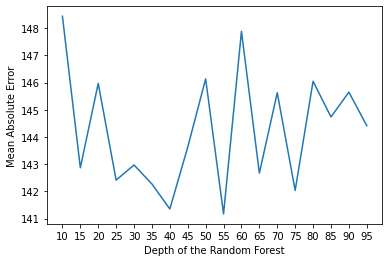

In [189]:
x = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
plt.plot(x,depth)
plt.xticks(x)
plt.xlabel("Depth of the Random Forest")
plt.ylabel("Mean Absolute Error")

In [167]:
df_log = pd.concat([df_man, df_woman])
df_log = df_log.sort_index()
df_log['Clinical F/U interval  [d from CT]'] = df['Clinical F/U interval  [d from CT]']
log_CT_1 = df_log[df_log["DEATH [d from CT]"] > 0].copy()
log_CT_2 = df_log[df_log["DEATH [d from CT]"].isna()].copy()

In [184]:
#test how many pass for alive
pipe = Pipeline([('sc', StandardScaler()),
                 ('clf', RandomForestRegressor(max_depth=20, random_state=0))
                    ])

l_2 = []
import time
for j in range(100):
    train, test = train_test_split(log_CT_1, test_size=0.2)    
    
    train_x = train[["L1_HU_BMD", 'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston', 'BA_EC']]
    train_y = train.iloc[:,-4]
    test_x = test[["L1_HU_BMD",'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston', 'BA_EC']]
    test_y = test.iloc[:,-4] 
    
    pipe.fit(train_x, train_y)
    temp = log_CT_2[["L1_HU_BMD", 'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston', 'BA_EC']]
    l = list(pipe.predict(temp))
    k = list(log_CT_2['Clinical F/U interval  [d from CT]'])
    count = 0
    for i in range(len(l)):
        if l[i] <= k[i]:
            count += 1

    l_2.append((len(l) - count)/len(l))

In [185]:
pipe = Pipeline([('sc', StandardScaler()),
                ('clf', RandomForestRegressor(max_depth=20, random_state=0))
                ])

l_1 = []

for j in range(100):
    train, test = train_test_split(log_1, test_size=0.2)
    train_x = train.iloc[:, :-1]
    train_y = train.iloc[:,-1]
    test_x = test.iloc[:, :-1]
    test_y = test.iloc[:,-1] 


    pipe.fit(train_x, train_y)
    temp = log_2.iloc[:, :-1]
    l = list(pipe.predict(temp))
    k = list(log_2['Clinical F/U interval  [d from CT]'])
    count = 0
    for i in range(len(l)):
        if l[i] <= k[i]:
            count += 1

    l_1.append((len(l) - count)/len(l))



Text(0, 0.5, 'At least above Clinic interval')

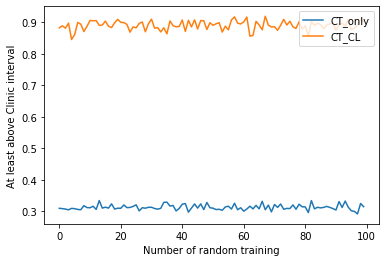

In [187]:
plt.plot(l_2, label = "CT_only")
plt.plot(l_1, label = "CT_CL")
plt.legend(loc="upper right")
plt.xlabel("Number of random training")
plt.ylabel("At least above Clinic interval")

In [190]:
#test BA/CA/without
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
pipe = Pipeline([('sc', StandardScaler()),
                 ('clf', RandomForestRegressor(max_depth=20, random_state=0))
                    ])

count = 0

BA_list = []
without_BA = []
CA_list = []
for i in range(100):
    train, test = train_test_split(log_CT_1, test_size=0.2)    
    
    train_x_BC = train[["L1_HU_BMD", 'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston', 'BA_EC']]
    train_y = train.iloc[:,-4]
    test_x_BC = test[["L1_HU_BMD",'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston', 'BA_EC']]
    test_y = test.iloc[:,-4] 


    train_x = train[["L1_HU_BMD", 'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston']]
    test_x = test[["L1_HU_BMD",'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston']]
    
    train_x_CA = train[["L1_HU_BMD", 'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston', 'Age at CT']]
    test_x_CA = test[["L1_HU_BMD",'L3 SMI (cm2/m2)','Muscle HU',' Muscle Area (cm2)', 'AoCa        Agatston', 'Age at CT']]
    
    pipe.fit(train_x_CA, train_y)
    l = list(pipe.predict(test_x_CA))
    CA_list.append(mean_absolute_error(test_y, l))
    
    pipe.fit(train_x_BC, train_y)
    l = list(pipe.predict(test_x_BC))
    BA_list.append(mean_absolute_error(test_y, l))
    
    pipe.fit(train_x, train_y)
    l = list(pipe.predict(test_x))
    without_BA.append(mean_absolute_error(test_y, l))

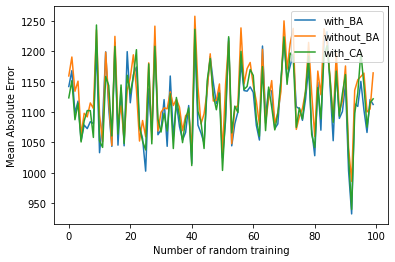

In [191]:
plt.plot(BA_list, label="with_BA")
plt.plot(without_BA, label="without_BA")
plt.plot(CA_list, label="with_CA")
plt.xlabel("Number of random training")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="upper right")

In [194]:
#bar of CT only, CT+CL, CT+BA
pipe = Pipeline([('sc', StandardScaler()),
                ('clf', RandomForestRegressor(max_depth=20, random_state=0))
                ])

CT_CL_list = []

for j in range(100):
    train, test = train_test_split(log_1, test_size=0.2)
    train_x = train.iloc[:, :-1]
    train_y = train.iloc[:,-1]
    test_x = test.iloc[:, :-1]
    test_y = test.iloc[:,-1] 


    pipe.fit(train_x, train_y)
    l = list(pipe.predict(test_x))
    CT_CL_list.append(mean_absolute_error(test_y, l))

Text(0, 0.5, 'Mean Absolute Error')

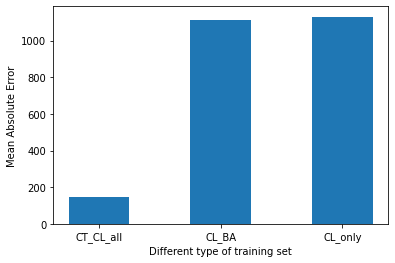

In [202]:
plt.bar(['CT_CL_all', 'CL_BA', 'CL_only'], [sum(CT_CL_list)/len(CT_CL_list), sum(BA_list)/len(BA_list), sum(without_BA)/len(without_BA)], width = 0.5)
plt.xlabel("Different type of training set")
plt.ylabel("Mean Absolute Error")

In [203]:
a = [sum(CT_CL_list)/len(CT_CL_list), sum(BA_list)/len(BA_list), sum(without_BA)/len(without_BA)]
a

[145.20037454545462, 1111.3507734865968, 1129.5951845486404]